# Data Loading and Initial Exploration

In [1]:
# Import necessary Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('MERGED_SDOH_PLUS_UTIL_24_RenamedColumns.csv')
df.head()

,CountyFIPS,State,County,Region,Pct_renter_occupied,Distance_to_medsurge_icu,Pct_renter_cost_50pct_plus,Pct_renter_cost_30pct_plus,Total_population_poverty,Pct_owner_cost_30plus,...,Pct_age_65plus,Pct_homes_no_vehicle,Pct_public_transit,Pct_single_parent,Pct_hh_no_internet,Distance_to_ED,Pct_mobile_homes,Pct_disabled,Is_Metro_Micro,Bed_util_ratio
0,1001,Alabama,Autauga County,South,24.941176,5.352941,28.352941,43.176470,55181.0,19.588235,...,15.352941,5.294117,0.470588,27.411764,82.352941,5.294117,17.882352,17.470588,1.0,0.378106
1,1003,Alabama,Baldwin County,South,22.727272,7.500000,19.545454,43.795454,215170.0,20.227272,...,21.681818,3.090909,0.045454,20.386363,83.204545,6.409090,12.159090,13.977272,1.0,0.504948
2,1005,Alabama,Barbour County,South,37.888888,8.666666,20.666666,46.222222,22070.0,16.333333,...,19.777777,11.888888,0.111111,47.777777,65.000000,8.666666,27.888888,19.111111,1.0,0.284690
3,1007,Alabama,Bibb County,South,24.500000,21.250000,27.750000,49.625000,20748.0,13.250000,...,16.250000,5.750000,0.000000,31.750000,74.875000,8.500000,33.250000,18.000000,1.0,0.286999
4,1009,Alabama,Blount County,South,24.062500,9.750000,23.562500,47.875000,57127.0,15.187500,...,18.500000,5.375000,0.125000,26.062500,80.187500,9.625000,25.500000,15.000000,1.0,0.304907


# Preprocessing, Encoding, Imputation

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# Train-test split calculator
def calcSplitRatio(df, p=None):
    if p is None:
        p = df.shape[1] - 1
    test_N = (1 / np.sqrt(p)) * len(df)
    test_prop = round(test_N / len(df), 2)
    train_prop = 1 - test_prop
    print(f"\nCalculated train/test split: {train_prop:.2f}/{test_prop:.2f}")
    return train_prop

# --- 1. Load and Initial Cleaning ---
df_cleaned = df.dropna(subset=["Region"])
df_cleaned = df_cleaned[df_cleaned["State"] != "District of Columbia"]

# Drop unnecessary columns
df_cleaned = df_cleaned.drop(columns=["State", "Land_area_sqmi", "Pct_renter_cost_30pct_plus"], errors="ignore")

# Drop rows with missing predictor values (except for Is_Metro_Micro and Bed_util_ratio)
predictor_cols = [col for col in df_cleaned.columns if col not in ["Bed_util_ratio", "Is_Metro_Micro"]]
df_cleaned = df_cleaned.dropna(subset=predictor_cols)

# --- 2. Split modeling vs missing target ---
df_modeling = df_cleaned[df_cleaned["Bed_util_ratio"].notnull()].copy()
df_missing_target = df_cleaned[df_cleaned["Bed_util_ratio"].isnull()].copy()

print(f"Modeling dataset shape (non-missing target): {df_modeling.shape}")
print(f"Rows with missing Bed_util_ratio preserved separately: {df_missing_target.shape}")

# --- 3. Train-Test Split ---
X = df_modeling.drop(columns=["Bed_util_ratio"])
y = df_modeling["Bed_util_ratio"]

split_ratio = calcSplitRatio(df_modeling)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split_ratio, random_state=42)

# --- 4. Encoding ---
for subset in [X_train, X_test]:
    subset["Is_Metro_Micro"] = subset["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})

# One-hot encode Region
X_train = pd.get_dummies(X_train, columns=["Region"], prefix="Region", drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Region"], prefix="Region", drop_first=True)

# Align columns between train and test
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Drop unused columns
X_train = X_train.drop(columns=["CountyFIPS", "County"], errors="ignore")
X_test = X_test.drop(columns=["CountyFIPS", "County"], errors="ignore")

# --- 5. Scaling and Imputation ---
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

knn = KNNImputer(n_neighbors=5)
X_train_scaled["Is_Metro_Micro"] = knn.fit_transform(X_train_scaled[["Is_Metro_Micro"]])
X_test_scaled["Is_Metro_Micro"] = knn.transform(X_test_scaled[["Is_Metro_Micro"]])

# --- 6. Reattach Targets ---
train_final = X_train_scaled.copy()
train_final["Bed_util_ratio"] = y_train
test_final = X_test_scaled.copy()
test_final["Bed_util_ratio"] = y_test

df_model_imputed = pd.concat([train_final, test_final]).sort_index()
df_model_imputed["Is_Metro_Micro"] = (df_model_imputed["Is_Metro_Micro"] >= 0.5).astype(int)

print("\nModeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.")
print(df_model_imputed.head())

# --- 7. Handle missing-target dataset ---
df_missing_target_encoded = df_missing_target.copy()

df_missing_target_encoded["Is_Metro_Micro"] = df_missing_target_encoded["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})
df_missing_target_encoded = pd.get_dummies(df_missing_target_encoded, columns=["Region"], prefix="Region", drop_first=True)

df_missing_target_encoded = df_missing_target_encoded.reindex(columns=X_train.columns.union(["state_encoded", "Is_Metro_Micro"]), fill_value=0)

df_missing_scaled = df_missing_target_encoded.copy()
df_missing_scaled = df_missing_scaled[X_train.columns]
df_missing_scaled = pd.DataFrame(scaler.transform(df_missing_scaled), columns=X_train.columns, index=df_missing_scaled.index)

df_missing_scaled["Is_Metro_Micro"] = knn.transform(df_missing_scaled[["Is_Metro_Micro"]])
df_missing_scaled["Is_Metro_Micro"] = (df_missing_scaled["Is_Metro_Micro"] >= 0.5).astype(int)

# Add placeholder Bed_util_ratio = NaN
df_missing_scaled["Bed_util_ratio"] = np.nan

# --- 8. Combine Full Dataset ---
df_final_full = pd.concat([df_model_imputed, df_missing_scaled], axis=0).sort_index()
print(f"\nFull dataset shape after re-integration: {df_final_full.shape}")
print(df_final_full.head())

# --- 9. Export ---
df_final_full.to_excel("final_full_dataset_with_preserved_missing_targets.xlsx", index=False)
print("\nExported full dataset with missing targets preserved.")

df_model_imputed.to_excel("modeling_dataset_only.xlsx", index=False)
print("Exported: modeling_dataset_only.xlsx")


Modeling dataset shape (non-missing target): (2391, 21)
Rows with missing Bed_util_ratio preserved separately: (751, 21)

Calculated train/test split: 0.78/0.22

Modeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.
   Pct_renter_occupied  Distance_to_medsurge_icu  Pct_renter_cost_50pct_plus  \
0            -0.425206                 -0.471017                    1.383843   
1            -0.699455                 -0.248219                    0.014196   
2             1.178700                 -0.127155                    0.188555   
3            -0.479857                  1.178608                    1.290080   
4            -0.534053                 -0.014738                    0.638884   

   Total_population_poverty  Pct_owner_cost_30plus  Population_density  \
0                 -0.184447               0.243717           -0.032985   
1                  0.265340               0.379438           -0.254184   
2                 -0.277534              -0.447575  

# Exploratory Analysis and Clustering

In [3]:
"""
PCA Exploration and Unsupervised Learning Analysis

This section performs in-depth exploratory analysis using the PCA-transformed data
and implements unsupervised learning techniques to identify patterns in hospital
bed utilization across geographic regions.

Component Interpretation:
- Analyzes top contributing features for each principal component
- PC1: Dominated by urban characteristics (population density, income)
- PC2: Represents social vulnerability factors (single parents, transportation access)
- PC3: Indicates aging population metrics
- Additional components capture regional and healthcare access features

Visualization and Loading Analysis:
- Creates PCA biplots with feature loadings
- Uses letter labels (A-T) for features to enhance readability
- Generates loading vectors showing feature influence on components
- Color-codes points by Bed_util_ratio for relationship exploration

K-Means Clustering:
- Implements elbow method to determine optimal cluster count
- Performs K-means clustering on first two principal components
- Calculates silhouette score to evaluate cluster quality
- Results indicate moderate cluster structure

Cluster Characterization:
- Identifies three distinct clusters based on feature patterns
- Each cluster represents different utilization profiles
- Analyzes geographic, demographic, and access characteristics

Geographic Visualization:
- Creates county-level choropleth maps using Plotly
- Maps cluster assignments to FIPS codes
- Shows spatial distribution of clusters across the United States
- Uses distinct color scheme for clear cluster differentiation

Cluster Statistics:
- Computes cluster means for all standardized features
- Identifies distinguishing characteristics of each cluster
- Exports cluster profiles for further interpretation
- Reveals underlying patterns in healthcare utilization

Key Findings:
- Three distinct healthcare utilization patterns emerge
- Urban-rural divide strongly influences bed utilization
- Socioeconomic factors correlate with healthcare access
- Regional variations show clear geographic patterns
"""


'\nPCA Exploration and Unsupervised Learning Analysis\n\nThis section performs in-depth exploratory analysis using the PCA-transformed data\nand implements unsupervised learning techniques to identify patterns in hospital\nbed utilization across geographic regions.\n\nComponent Interpretation:\n- Analyzes top contributing features for each principal component\n- PC1: Dominated by urban characteristics (population density, income)\n- PC2: Represents social vulnerability factors (single parents, transportation access)\n- PC3: Indicates aging population metrics\n- Additional components capture regional and healthcare access features\n\nVisualization and Loading Analysis:\n- Creates PCA biplots with feature loadings\n- Uses letter labels (A-T) for features to enhance readability\n- Generates loading vectors showing feature influence on components\n- Color-codes points by Bed_util_ratio for relationship exploration\n\nK-Means Clustering:\n- Implements elbow method to determine optimal clust

# PCA

## PCA Setup with Box-Cox Transformation

Box-Cox Lambda: 0.7989


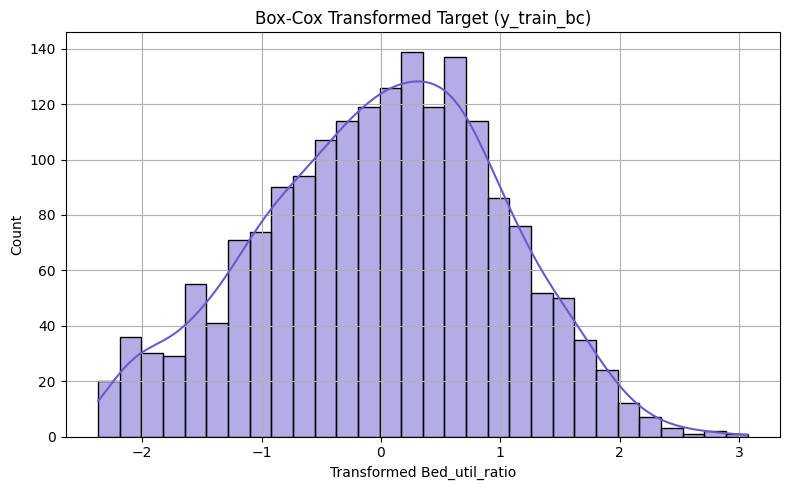

Shapiro-Wilk Test for Normality of Transformed Target:
W = 0.9930, p = 0.0000
Transformed target likely not normal.


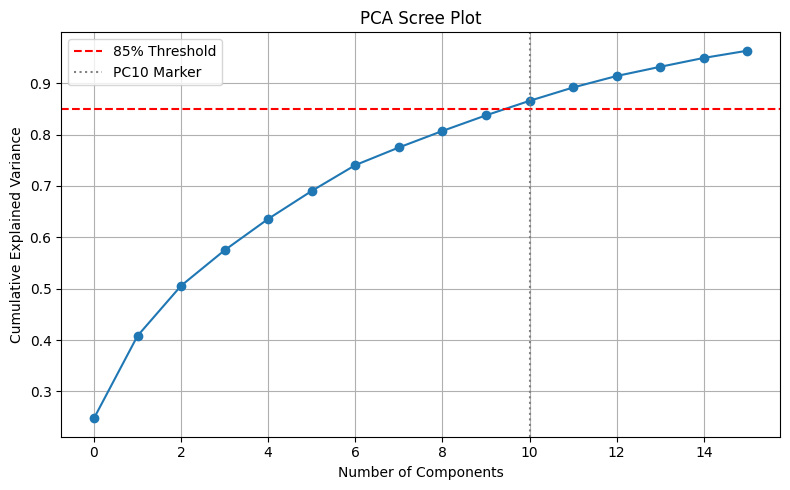

,Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.247705,0.247705
1,PC2,0.160430,0.408134
2,PC3,0.097567,0.505701
3,PC4,0.069142,0.574843
4,PC5,0.060934,0.635777
5,PC6,0.054443,0.690219
6,PC7,0.050238,0.740458
7,PC8,0.034305,0.774763
8,PC9,0.032176,0.806939
9,PC10,0.030380,0.837318


Original shape (X_train_scaled): (1864, 20)
Reduced shape after PCA (train): (1864, 16)
Reduced shape after PCA (test): (527, 16)


In [4]:
"""
This cell continues from the preprocessing pipeline and assumes the following
variables are already defined:
- X_train_scaled, X_test_scaled: scaled feature sets (with no missing values)
- y_train, y_test: untransformed target values (may include small or non-positive values)

This step performs:
- Box-Cox transformation on the target (Bed_util_ratio) to correct skewness and approximate normality
    - Applies safe shifting for Box-Cox if any values are ≤ 0
    - Includes diagnostic checks: histogram and Shapiro-Wilk test
- Principal Component Analysis (PCA) on the scaled features to reduce dimensionality
    - Retains enough components to explain ≥95% of variance
    - Visualizes cumulative explained variance via a scree plot

Final outputs:
- Transformed target: y_train_bc, y_test_bc
- Reduced feature sets: X_train_pca, X_test_pca
- Diagnostic outputs for lambda, distribution, normality, and variance retention
"""


# --- Box-Cox Transformation + PCA Setup ---

from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from scipy.special import inv_boxcox
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Shift the target if needed (Box-Cox requires strictly positive values)
if (y_train <= 0).any():
    shift_amount = abs(y_train.min()) + 0.01
    y_train_shifted = y_train + shift_amount
    y_test_shifted = y_test + shift_amount
else:
    shift_amount = 0
    y_train_shifted = y_train
    y_test_shifted = y_test

# Apply Box-Cox
pt = PowerTransformer(method='box-cox')
y_train_bc = pt.fit_transform(y_train_shifted.values.reshape(-1, 1)).flatten()
y_test_bc = pt.transform(y_test_shifted.values.reshape(-1, 1)).flatten()
lambda_bc = pt.lambdas_[0]

# ----------------------
# Box-Cox Diagnostic Output

print(f"Box-Cox Lambda: {lambda_bc:.4f}")

# Histogram of Box-Cox Transformed Target
plt.figure(figsize=(8, 5))
sns.histplot(y_train_bc, bins=30, kde=True, color='slateblue')
plt.title("Box-Cox Transformed Target (y_train_bc)")
plt.xlabel("Transformed Bed_util_ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

# Shapiro-Wilk Normality Test
from scipy.stats import shapiro

stat_bc, p_bc = shapiro(y_train_bc)
print(f"Shapiro-Wilk Test for Normality of Transformed Target:")
print(f"W = {stat_bc:.4f}, p = {p_bc:.4f}")
if p_bc > 0.05:
    print("Transformed target appears approximately normal.")
else:
    print("Transformed target likely not normal.")

# ----------------------
# ------------PCA----------------

# PCA on scaled features
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')

plt.axhline(y=0.85, color='r', linestyle='--', label='85% Threshold')
plt.axvline(x=10, color='grey', linestyle='dotted', label='PC10 Marker')

plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# View explained variance (optional)
explained_variance = pd.DataFrame({
    "Component": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "Explained Variance Ratio": pca.explained_variance_ratio_,
    "Cumulative Variance": np.cumsum(pca.explained_variance_ratio_)
})
display(explained_variance.head(10))

# --- Final Output ---
# Inspect original shape ---
print("Original shape (X_train_scaled):", X_train_scaled.shape)
print("Reduced shape after PCA (train):", X_train_pca.shape)
print("Reduced shape after PCA (test):", X_test_pca.shape)



## PCA Plots with Loadings

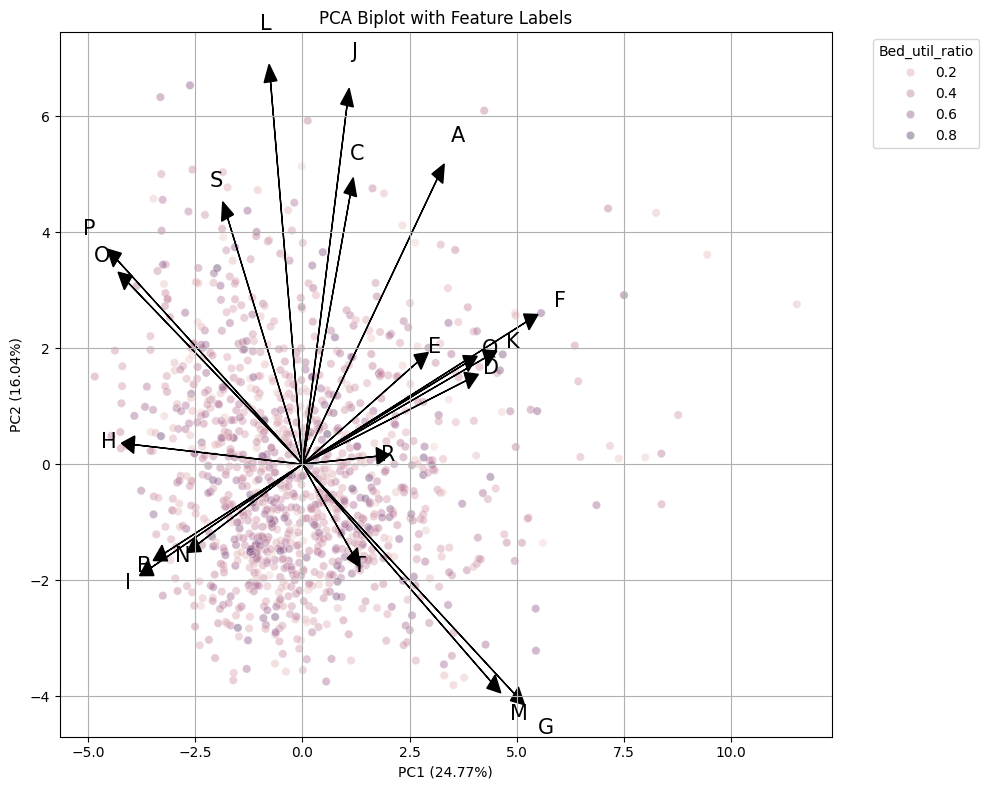

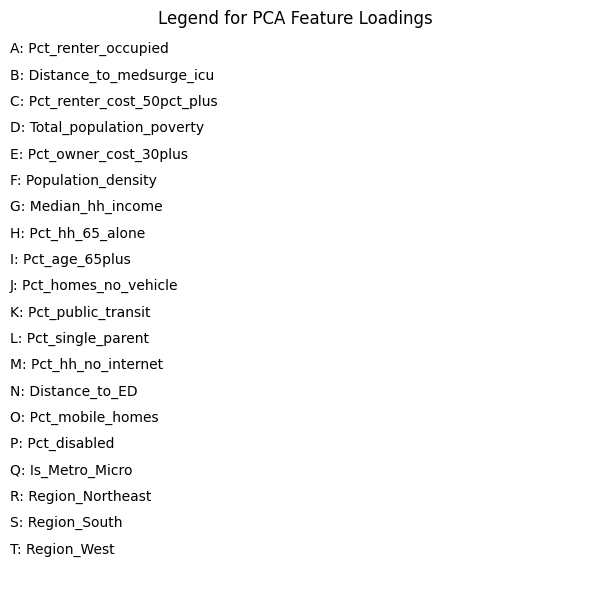

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import string


#our variables
feature_names = X_train_scaled.columns.tolist()

# Create PCA DataFrame for plotting using df_final_full
pca_df = pd.DataFrame(X_train_pca[:, :2], columns=["PC1", "PC2"])

# Loadings for the first two components
loadings = pd.DataFrame(
    pca.components_[:2].T,
    columns=["PC1", "PC2"],
    index=X_train_scaled.columns
)

# Generate label map based on PCA loadings (actual features used)
feature_names = loadings.index.tolist()
feature_labels = list(string.ascii_uppercase[:len(feature_names)])
label_map = dict(zip(feature_names, feature_labels))



# Define the loading_plot function
def loading_plot(coeff, labels, scale=6, colors=None, visible=None, ax=plt, arrow_size=0.05, font_size=12):
  for i, label in enumerate(labels):
      if visible is None or visible[i]:
          ax.arrow(0, 0,
                    coeff[i, 0] * scale,
                    coeff[i, 1] * scale,
                    head_width=arrow_size * scale,
                    head_length=arrow_size * scale,
                    color="#000" if colors is None else colors[i])
          ax.text(coeff[i, 0] * 1.15 * scale,
                  coeff[i, 1] * 1.15 * scale,
                  label_map.get(label, label),  # Safe fallback
                  color="#000" if colors is None else colors[i],
                  ha="center", va="center", fontsize=font_size)




# Plot PCA biplot with feature loadings
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", data=pca_df, hue=df_final_full.loc[X_train_scaled.index, "Bed_util_ratio"], alpha=0.4)
loading_plot(loadings.values, labels=loadings.index, scale=15, arrow_size=0.02, font_size=15)


# Add axis labels and title
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("PCA Biplot with Feature Labels")

# Add a legend in the top right corner for Bed_util_ratio
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), title='Bed_util_ratio')

# Show grid and finalize plot layout
plt.grid(True)
plt.tight_layout()
plt.show()

# Create legend
legend_labels = [f"{label_map.get(name, name)}: {name}" for name in feature_names]


plt.figure(figsize=(6, len(legend_labels) * 0.3))
plt.axis('off')
for i, txt in enumerate(legend_labels):
    plt.text(0, 1 - i * 0.05, txt, fontsize=10)
plt.title("Legend for PCA Feature Loadings\n", fontsize=12)
plt.tight_layout()

plt.show()

## View - Top Predicters for PC1 only

In [6]:
"""
This cell analyzes the contribution of original features to the first 10 principal components generated by PCA.

Purpose:
- To interpret what the principal components represent in terms of the original features
- To identify which features most strongly influence each component, especially PC1

Steps performed:
- Converts the PCA-transformed NumPy array (X_train_scaled) into a labeled DataFrame using the original feature names
- Constructs a PCA loadings matrix ('loadings_df'), where:
    - Rows = Principal Components (PC1–PC10)
    - Columns = Original features
    - Cell values = correlation-like weights (loadings) showing each feature's contribution to that component
- Extracts and displays the top 10 most influential features (by absolute loading value) for the first principal component (PC1)

Interpretation:
- Features with the highest absolute loadings for PC1 are the strongest contributors to the variance captured by that component.
- This allows labeling PCs (e.g., "Urban Density and Access Barriers") and drawing real-world conclusions from otherwise abstract components.
"""

# Extract original column names from X_train before scaling
original_feature_names = X_train.columns

# Adding Column names to:
X_scaled_df = pd.DataFrame(X_train_scaled, columns=original_feature_names)

# Automatically adjust to actual number of retained PCs
n_components = pca.n_components_

loadings_df = pd.DataFrame(
    pca.components_[:n_components],
    columns=X_scaled_df.columns,
    index=[f"PC{i+1}" for i in range(n_components)]
)


# Show top contributing features to PC1
top_pc1 = loadings_df.loc["PC1"].abs().sort_values(ascending=False)
print("Top contributing features to PC1:")
print(top_pc1.head(10))


Top contributing features to PC1:
Population_density          0.348197
Median_hh_income            0.329753
Pct_hh_no_internet          0.293295
Pct_disabled                0.287865
Pct_public_transit          0.284012
Pct_mobile_homes            0.270839
Pct_hh_65_alone             0.261613
Total_population_poverty    0.254900
Is_Metro_Micro              0.253635
Pct_age_65plus              0.235502
Name: PC1, dtype: float64


## View - Top Predicters for Top 5 Principle Components only

In [7]:
"""
Displays the top 5 contributing original features for each of the first 10 principal components.
Helps interpret what each PC represents in terms of feature influence.
"""

for pc in loadings_df.index:
    top_features = loadings_df.loc[pc].abs().sort_values(ascending=False).head(5)
    print(f"\nTop features in {pc}:")
    print(top_features)




Top features in PC1:
Population_density    0.348197
Median_hh_income      0.329753
Pct_hh_no_internet    0.293295
Pct_disabled          0.287865
Pct_public_transit    0.284012
Name: PC1, dtype: float64

Top features in PC2:
Pct_single_parent             0.439723
Pct_homes_no_vehicle          0.412314
Pct_renter_occupied           0.328235
Pct_renter_cost_50pct_plus    0.309804
Region_South                  0.283151
Name: PC2, dtype: float64

Top features in PC3:
Pct_age_65plus           0.436337
Pct_hh_65_alone          0.399567
Pct_owner_cost_30plus    0.368368
Region_South             0.311490
Region_Northeast         0.286084
Name: PC3, dtype: float64

Top features in PC4:
Region_West              0.550446
Distance_to_ED           0.399050
Pct_mobile_homes         0.333503
Region_Northeast         0.318935
Pct_owner_cost_30plus    0.290926
Name: PC4, dtype: float64

Top features in PC5:
Distance_to_medsurge_icu      0.410629
Pct_renter_cost_50pct_plus    0.387836
Is_Metro_Micro    

## Using PCA to Identify Clusters (K-Means)

In [8]:
from sklearn.cluster import KMeans

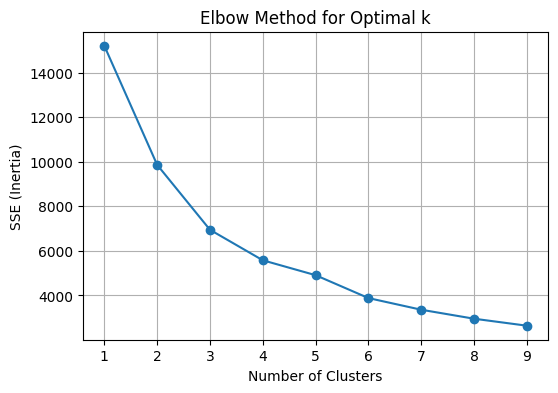

In [9]:
# elbow method for identifying 'k'
sse = []
for k in range(1, 10):
    km = KMeans(n_clusters = k, random_state = 42)
    km.fit(pca_df[["PC1", "PC2"]])
    sse.append(km.inertia_)

plt.figure(figsize = (6, 4))
plt.plot(range(1, 10), sse, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [10]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df)

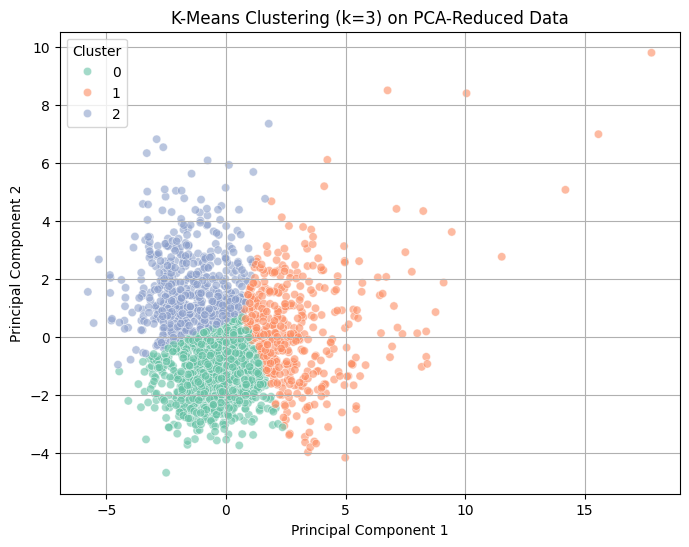

In [11]:
# Plot
plt.figure(figsize = (8, 6))
sns.scatterplot(
    x = 'PC1', y = 'PC2',
    data = pca_df,
    hue = 'Cluster',
    palette = 'Set2',
    alpha = 0.6
)
plt.title('K-Means Clustering (k=3) on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title = 'Cluster')
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import silhouette_score

score = silhouette_score(pca_df[['PC1', 'PC2']], pca_df['Cluster'])
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.349


The Silhouette Score measures how similar a point is to its own cluster vs. other clusters.

Ranges from -1 to 1.

Closer to 1 = well-clustered.

Near 0 = overlapping clusters.

Negative = misclassified points.

Our score is below 0.5, which means the structure isn't super distinct and there's likely some overlap or ambiguous boundaries between the clusters.

# County-Level Choropleth Cluster Map

In [13]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
labels = kmeans.fit_predict(pca_df)
df = pd.DataFrame(X_train_scaled, columns = feature_names)
df['Cluster'] = labels
cluster_means = df.groupby('Cluster').mean()
#print(cluster_means, file = open("cluster_means.tsv", "w"))
print(cluster_means)

         Pct_renter_occupied  Distance_to_medsurge_icu  \
Cluster                                                  
0                  -0.504294                  0.230642   
1                   0.116475                  0.093216   
2                   0.832674                 -0.579996   

         Pct_renter_cost_50pct_plus  Total_population_poverty  \
Cluster                                                         
0                         -0.498335                 -0.232231   
1                          0.429259                 -0.215257   
2                          0.395695                  0.749049   

         Pct_owner_cost_30plus  Population_density  Median_hh_income  \
Cluster                                                                
0                    -0.268021           -0.319527          0.059349   
1                    -0.082272           -0.302040         -0.790842   
2                     0.638574            1.038595          0.958620   

         Pct_hh_65_alo

In [14]:
# extract FIPS from the cleaned dataset using the same indices used in training
fips_train = df_cleaned.loc[X_train_scaled.index, ['CountyFIPS']].copy()

fips_train['Cluster'] = labels
print(fips_train.head())

      CountyFIPS  Cluster
1305       26139        0
400        13017        1
2692       48329        2
143         5055        1
1436       28061        1


In [15]:
fips_train["CountyFIPS"] = fips_train["CountyFIPS"].astype(str).str.zfill(5)

In [19]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'colab'


fig = px.choropleth(
    fips_train,
    geojson = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations = "CountyFIPS",
    color = "Cluster",  # categorical
    range_color=(0, 2),
    scope = "usa",
    labels = {"Cluster": "Cluster Group"},
    color_discrete_map = {
        0: "#69C2A5",
        1: "#FA8C67",
        2: "#8EA0C9"
    }
)

fig.update_geos(fitbounds = "locations", visible = False)

fig.update_layout(
    title = {
        'text': "County-Level Clusters (K-Means)",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24}
    }
)

#pio.renderers.default = 'browser'
#fig.show()
fig.show(renderer='colab')